# Classification using VGG19+Grad CAM+Saliency Map with augmentation of Cycle GAN

References:

https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/ 

@Auther Adrian Rosebrock

https://fairyonice.github.io/Grad-CAM-with-keras-vis.html 

@Auther Yumi 

https://fairyonice.github.io/Saliency-Map-with-keras-vis.html 

@Auther Yumi

Modified the VGG19 model based on the Code of the groupmate Nicolai Schneider

Modified the plot function of the Grad-CAM for project ML in Medical IP

Modified the plot function of Saliency Map for project ML in Medical IP


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
#import tensorflow as tf
from tensorflow import keras
import keras

import os
import numpy as np
import cv2
import pandas as pd
import random
import math
#import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [5]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [6]:
# get the data
dataDirAugmented = "C:/home/lin/Downloads/data"
dataDirTrain = "C:/home/lin/Downloads/data/train"
dataDirVal = "C:/home/lin/Downloads/data/val"

categories = ["bacterial","covid19","normal","viral"]

trainingData = []
imgSize = 128

err = 0
evals = 0

# training data
for category in categories:
    # get class label and category directory
    classIndex = categories.index(category)
    categoryDir = category        
    path = os.path.join(dataDirTrain, categoryDir)
        
    # iterate through images
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (imgSize, imgSize))
            image = img_to_array(new_array)
            trainingData.append([image, classIndex])
            evals += 1
            if evals%100 == 0:
                print("+100 (train) " + category)

        except Exception as e:
            print(path)
            print(img)
            print(e)
            err += 1
            break

            
# validation data
for category in categories:
    # get class label and category directory
    classIndex = categories.index(category)
    categoryDir = category
    path = os.path.join(dataDirVal, categoryDir)
    
    # iterate through images
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (imgSize, imgSize))
            image = img_to_array(new_array)
            trainingData.append([image, classIndex])
            evals += 1
            if evals%100 == 0:
                print("+100 (val) " + category)
        except Exception as e:
            err += 1
            pass

print(len(trainingData))
print(err)

# randomize
for l in range(10):
    random.seed(l)
    random.shuffle(trainingData)


+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) bacterial
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) covid19
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+100 (train) normal
+1

In [7]:
# split into x (features) and y (labels)
data = []
labels = []

for feature,label in trainingData:
    data.append(feature)
    labels.append(label)
    
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)

In [8]:
(xtrain_,xtest,ytrain_,ytest)=train_test_split(data,labels,test_size=0.1,random_state=42,shuffle=False)

(xtrain,xval,ytrain,yval)=train_test_split(xtrain_,ytrain_,test_size=0.25,random_state=56,shuffle=False)
# print(xtrain.shape, xtest.shape)

print("Shape of test data")
print(xtest.shape)

print()
print("Shape of train/validation data")
print(xtrain.shape, xval.shape)

Shape of test data
(768, 128, 128, 3)

Shape of train/validation data
(5181, 128, 128, 3) (1727, 128, 128, 3)


In [9]:
import keras
from keras import models
from keras import layers
from keras.models import Model
from keras.applications import VGG16,Xception,VGG19
from keras.applications.densenet import DenseNet121
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import AveragePooling2D

In [10]:
# VGG16 model
conv_base = VGG19(weights='imagenet',include_top=False, input_shape=(imgSize, imgSize, 3))
headModel = conv_base.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=conv_base.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in conv_base.layers:
    layer.trainable = True
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0002,decay=0.0002 / 20),
              metrics=['accuracy']) 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [30]:
history = model.fit(xtrain, 
                     ytrain, 
                     validation_data=[xval,yval],
                     batch_size= 64, 
                     epochs = 1)
model.save_weights("covid_weights_vgg19_1")

Train on 5181 samples, validate on 1727 samples
Epoch 1/1
5181/5181 [==============================] - 42s 8ms/step - loss: 0.0939 - accuracy: 0.9676 - val_loss: 0.4501 - val_accuracy: 0.8854


In [11]:
# model.load_weights("covid_weights_vgg19_1_87")

In [10]:
# make predictions on the testing set
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
classes = ["Bact. Pn.","COVID","Normal","Viral Pn."]
y_pred = model.predict(xtest, batch_size=25)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
y_pred = np.argmax(y_pred, axis=1)
# show a nicely formatted classification report
print(classification_report(ytest.argmax(axis=1), y_pred,target_names=classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

   Bact. Pn.       0.89      0.70      0.78       214
       COVID       0.96      0.92      0.94       133
      Normal       0.92      0.97      0.94       203
   Viral Pn.       0.77      0.91      0.83       218

    accuracy                           0.87       768
   macro avg       0.88      0.87      0.87       768
weighted avg       0.87      0.87      0.87       768



Text(0.5, 145.31999999999996, 'Predicted')

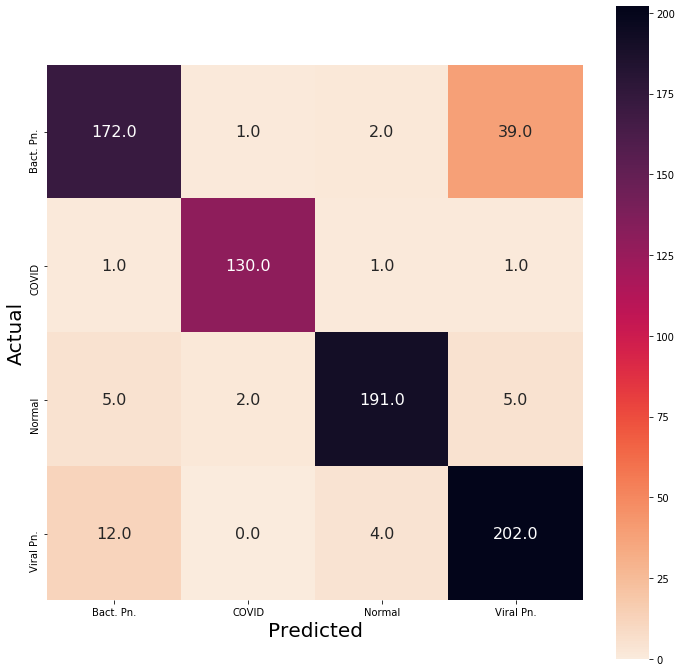

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

ytrue = np.argmax(ytest, axis=1)

catLabel = ["Bact. Pn.","COVID","Normal","Viral Pn."]
confMatrix = confusion_matrix(ytrue, y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(confMatrix, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=catLabel, yticklabels=catLabel)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

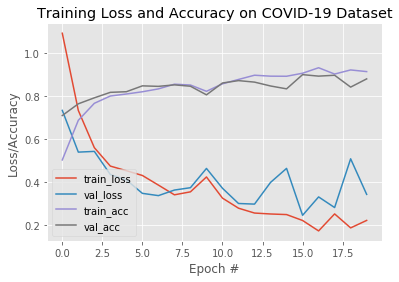

In [18]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# Grad CAM

In [12]:
import vis
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image
import matplotlib.cm as cm
import scipy
from vis.utils import utils
from vis.visualization import visualize_cam

In [13]:
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

  0 input_1   
  1 block1_conv1
  2 block1_conv2
  3 block1_pool
  4 block2_conv1
  5 block2_conv2
  6 block2_pool
  7 block3_conv1
  8 block3_conv2
  9 block3_conv3
 10 block3_conv4
 11 block3_pool
 12 block4_conv1
 13 block4_conv2
 14 block4_conv3
 15 block4_conv4
 16 block4_pool
 17 block5_conv1
 18 block5_conv2
 19 block5_conv3
 20 block5_conv4
 21 block5_pool
 22 flatten   
 23 dense_1   
 24 dropout_1 
 25 dense_2   


In [14]:
layer_idx = utils.find_layer_idx(model, 'dense_2')

In [16]:
def plot_map(grads,img):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img[:,:,0],cmap='gray')
    axes[1].imshow(img[:,:,0],cmap='gray')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f} and the true class is {}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))

Top 1 predicted class:     Pr(Class=Bacterial          [index=0])=1.000
Top 2 predicted class:     Pr(Class=Viral              [index=3])=0.000
Top 3 predicted class:     Pr(Class=Normal             [index=2])=0.000
Top 4 predicted class:     Pr(Class=COVID-19           [index=1])=0.000
true label: [1 0 0 0]
Top 1 predicted class:     Pr(Class=COVID-19           [index=1])=1.000
Top 2 predicted class:     Pr(Class=Bacterial          [index=0])=0.000
Top 3 predicted class:     Pr(Class=Normal             [index=2])=0.000
Top 4 predicted class:     Pr(Class=Viral              [index=3])=0.000
true label: [0 1 0 0]
Top 1 predicted class:     Pr(Class=Normal             [index=2])=1.000
Top 2 predicted class:     Pr(Class=Viral              [index=3])=0.000
Top 3 predicted class:     Pr(Class=Bacterial          [index=0])=0.000
Top 4 predicted class:     Pr(Class=COVID-19           [index=1])=0.000
true label: [0 0 1 0]
Top 1 predicted class:     Pr(Class=Viral              [index=3])=0.99

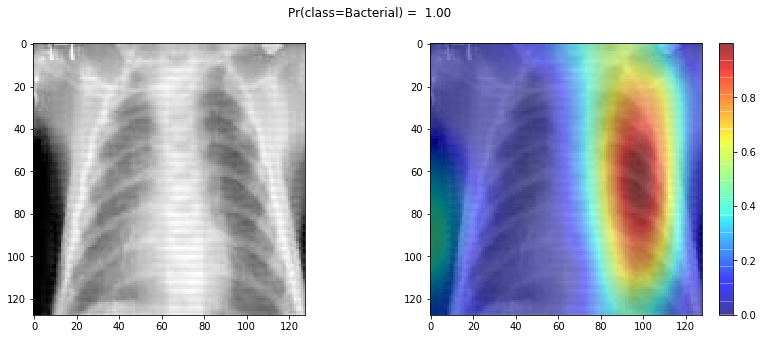

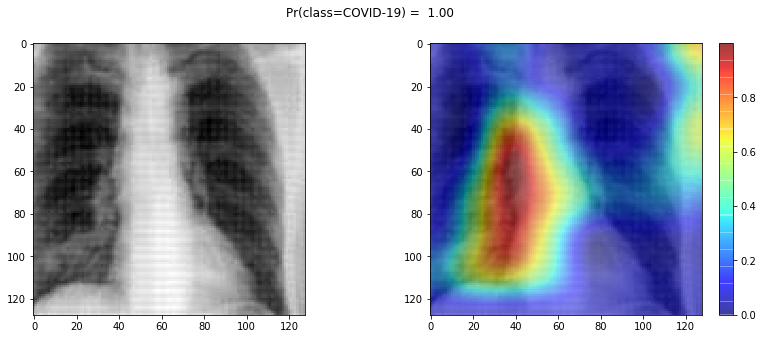

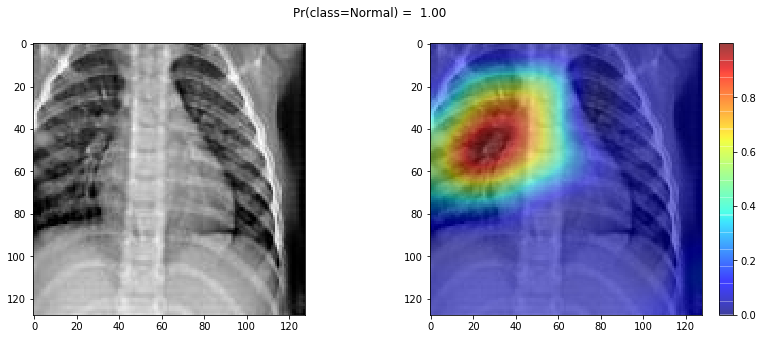

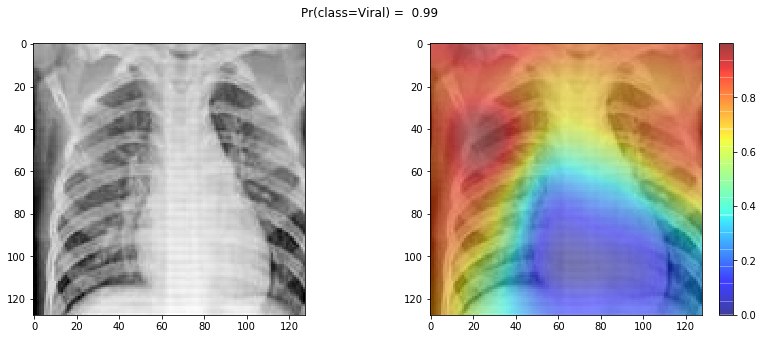

In [26]:
from keras.applications.vgg16 import preprocess_input
from vis.visualization import visualize_cam
# choose the images you want to check in the test set
imgn=[25,50,765,52]    
for imgnum in imgn:

    model.layers[layer_idx].activation = keras.activations.softmax
    model = utils.apply_modifications(model)
    img               = img_to_array(xtest[imgnum])
    #img               = preprocess_input(img)
    classlabel= ["Bacterial","COVID-19","Normal","Viral"]
    y_pred            = model.predict(img[np.newaxis,...])
    class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
    topNclass         = 4
    for i, idx in enumerate(class_idxs_sorted[:topNclass]):
        print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
              i + 1,classlabel[idx],idx,y_pred[0,idx]))
    print('true label:',ytest[imgnum])  
    penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv4") 
    class_idx  = class_idxs_sorted[0]
    model.layers[layer_idx].activation = keras.activations.linear
    model = utils.apply_modifications(model)
    seed_input = img
    grad1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                               penultimate_layer_idx = penultimate_layer_idx,#None,
                               backprop_modifier     = None,
                               grad_modifier         = None)
    plot_map(grad1,img)

# Saliency Map

In [15]:
import scipy.ndimage as ndimage
from vis.visualization import visualize_saliency
def plot_saliency(grads,img,idx):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img[:,:,0],cmap='gray')
    i = axes[1].imshow(grads,cmap='jet',alpha=.9)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f} and the true class is {}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx],classlabel[idx]))


Top 1 predicted class:     Pr(Class=Viral              [index=3])=0.860
Top 2 predicted class:     Pr(Class=Bacterial          [index=0])=0.140
Top 3 predicted class:     Pr(Class=Normal             [index=2])=0.000
Top 4 predicted class:     Pr(Class=COVID-19           [index=1])=0.000
true label: [1 0 0 0]
Top 1 predicted class:     Pr(Class=Bacterial          [index=0])=0.720
Top 2 predicted class:     Pr(Class=Viral              [index=3])=0.280
Top 3 predicted class:     Pr(Class=Normal             [index=2])=0.000
Top 4 predicted class:     Pr(Class=COVID-19           [index=1])=0.000
true label: [0 0 0 1]


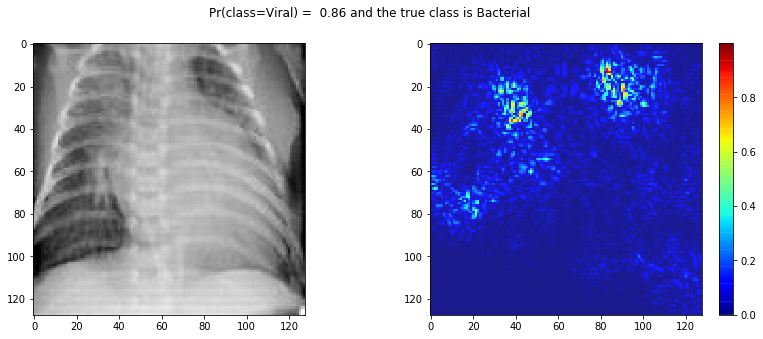

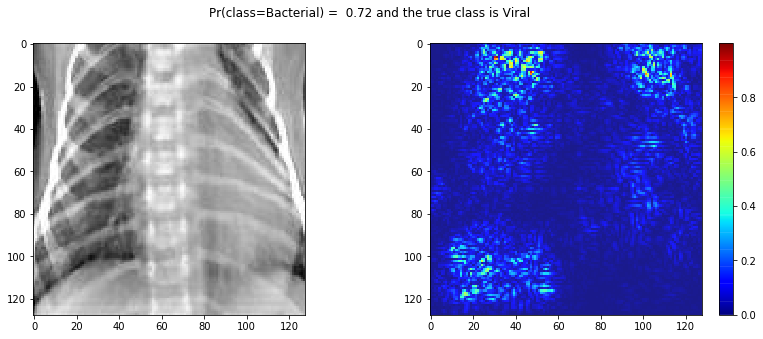

In [18]:
imgn=[ 81,  203]  
for imgnum in imgn:

    model.layers[layer_idx].activation = keras.activations.softmax
    model = utils.apply_modifications(model)
    img               = img_to_array(xtest[imgnum])
    #img               = preprocess_input(img)
    classlabel= ["Bacterial","COVID-19","Normal","Viral"]
    y_pred            = model.predict(img[np.newaxis,...])
    class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
    topNclass         = 4
    for i, idx in enumerate(class_idxs_sorted[:topNclass]):
        print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
              i + 1,classlabel[idx],idx,y_pred[0,idx]))
    print('true label:',ytest[imgnum])  
    penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv4") 
    class_idx  = class_idxs_sorted[0]
    grad1 = visualize_saliency(model,layer_idx,filter_indices=class_idx,seed_input=img[np.newaxis,...],backprop_modifier=None,grad_modifier='absolute')
    model.layers[layer_idx].activation = keras.activations.linear
    model = utils.apply_modifications(model)
    plot_saliency(grad1,img,np.argmax(ytest[imgnum]))